# Copy of Previous RNN

### Reminders:

Read up on some of these:
- https://machinelearningmastery.com/stateful-stateless-lstm-time-series-forecasting-python/
- https://fairyonice.github.io/Stateful-LSTM-model-training-in-Keras.html 
- https://github.com/keras-team/keras/issues/5714
- https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/

###Shuffle Data!!!!!



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pre-processing

## Do Basic Imports

In [2]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
import pandas
from matplotlib import pyplot as plt
from math import isnan
from scipy.stats import norm

pandas.set_option('display.max_columns', None)
np.set_printoptions(suppress=True, precision=3)

## Obtain data

In [3]:
# read data from drive
csv_train = pandas.read_csv("drive/MyDrive/first_10k.csv")
unparsed_train = np.array(csv_train)

## Parse Data

The data is a 403 value array with the following splits:



In [ ]:
print(csv_train.keys()[0:6])  # labels
print(csv_train.keys()[6:31]) # cov
print(csv_train.keys()[31:56])# invcov
print(csv_train.keys()[56:59])# fit
print(csv_train.keys()[59:67])# timers
# print(csv_train.keys()[67:81])# hit1
print(csv_train.keys()[67:69])# hit1
print(csv_train.keys()[73:81],"\n")# hit1
print(csv_train.keys()[67:])  # hit
print(unparsed_train.shape)

Index(['event', 'q_over_pt', 'phi', 'tanl', 'D', 'z'], dtype='object')
Index(['cov_00', 'cov_01', 'cov_02', 'cov_03', 'cov_04', 'cov_10', 'cov_11',
       'cov_12', 'cov_13', 'cov_14', 'cov_20', 'cov_21', 'cov_22', 'cov_23',
       'cov_24', 'cov_30', 'cov_31', 'cov_32', 'cov_33', 'cov_34', 'cov_40',
       'cov_41', 'cov_42', 'cov_43', 'cov_44'],
      dtype='object')
Index(['invcov_00', 'invcov_01', 'invcov_02', 'invcov_03', 'invcov_04',
       'invcov_10', 'invcov_11', 'invcov_12', 'invcov_13', 'invcov_14',
       'invcov_20', 'invcov_21', 'invcov_22', 'invcov_23', 'invcov_24',
       'invcov_30', 'invcov_31', 'invcov_32', 'invcov_33', 'invcov_34',
       'invcov_40', 'invcov_41', 'invcov_42', 'invcov_43', 'invcov_44'],
      dtype='object')
Index(['chisq', 'Ndof', 'rms'], dtype='object')
Index(['t_start_cntr', 't_start_cntr_valid', 't_tof', 't_tof_valid', 't_bcal',
       't_bcal_valid', 't_fcal', 't_fcal_valid'],
      dtype='object')


Index(['hit1_u', 'hit1_v'], dtype='object')


### Normalize

#### Absolute Normalizer

Find the smallest and largest values in training sample data (67,403) and store them for later use

In [ ]:
max = -1000
min = 1000
for event in unparsed_train:
  norm_data = []
  for i in range(67,403):
    if event[i] > max:
      max = event[i]
    if event[i] < min:
      min = event[i]

#### Variable Normalizer

Find smallest and largest value for each of the 14 variables in train hit data and store them for later use

In [ ]:
_max = [-1000 for i in range(10)]
_min = [1000 for i in range(10)]
for index,event in enumerate(unparsed_train):
  lower = 67
  for upper in range(lower+14, event.shape[0]+1, 14):
    d = event[lower:upper]
    d = np.append(d[:2],d[6:])
    for a in range(len(d)):
      if d[a] > _max[a]:
        _max[a] = d[a]
      if d[a] < _min[a]:
        _min[a] = d[a]
    lower = upper
print(_max)
print(_min)

[47.588573718740314, 47.716949659038654, 47.920741252343745, 0.04333333333333333, 96.0, 24.0, 343.5052137331197, 274.8641357421875, 3.24600255369344e-07, 137.76808719278492]
[-47.69482374702719, -47.64816097490715, -47.78196688638672, 0.010072585750472143, 1.0, 1.0, 176.8656847042481, -77.76896667480467, 7.068405941829982e-10, 0.3]


### Whole data parser

Take the data input and convert it into python list of numpy ndarrays of shape: (1,hits,14)

It will normalize each of the 14 variables seperately using the "Variable Normalizer" from above.


In [ ]:
def parser(unparsed):
  global _min, _max
  x_final = []
  y_final = []
  other_final = []
  for event in unparsed:
    x = []
    y = []
    other = []

    nEvent = event[0]
    state = event[1:6]
    coVar = event[6:31]
    invCoVar = event[31:56]
    goodnessOfFit = event[56:59]
    TOF = event[59:67]


    if goodnessOfFit[2] > 0.1:
      continue

    other = np.append(TOF, invCoVar)


    hits = []

    lower = 67
    for upper in range(lower+14, event.shape[0]+1, 14): # to flip just go from end to 67 by -14 steps?
      hasNAN = False
      for val in event[lower:upper]:
        if isnan(val):
          hasNAN = True
      if not hasNAN:
        hit_data = event[lower:upper]
        hit_data = np.append(hit_data[:2],hit_data[6:])
        # --== Using absolute normalizer ==--
        # hit_data = (hit_data - min) / (max - min)
        # hits.append(hit_data)
        
        for z in range(len(hit_data)):
          hit_data[z] = (hit_data[z] - _min[z]) / (_max[z] - _min[z])
        
        # hit_data = np.append(hit_data,TOF)
        # hit_data = np.append(hit_data)

        hits.append(hit_data)
      else:
        hits.append([0 for z in range(10)])
        # hits.append([0 for z in range(18)])
      lower = upper
    hits = np.array(hits)

    for i in range(hits.shape[0]):
      x.append(hits[i])
      # y.append(hits[i+1])
      # y.append(state)
    y = state

    # x = np.expand_dims(np.array(x),0)
    # y = np.expand_dims(np.array(y),0)

    x_final.append(x)
    y_final.append(y)
    other_final.append(other)

  x_final = np.array(x_final)
  y_final = np.array(y_final)
  other_final = np.array(other_final)

  return x_final, y_final, other_final

In [ ]:
x_train, y_train, other_train = parser(unparsed_train)
# print(len(x_train))
# if len(x_train) >= 5:
#   for i in range(5):
#     print(x_train[i].shape)
# else:
#   for i in range(len(x_train)):
#     print(x_train[i].shape)

# print(x_train.shape)

i = 0
print("x_shape:", x_train[i].shape)
print("y_shape:", y_train[i].shape)
print("other s:", other_train[i].shape)
print("x:\n",x_train[i])
print("y:\n",y_train[i])
print("o:\n",other_train[i])

x_shape: (24, 10)
y_shape: (5,)
other s: (33,)
x:
 [[0.769 0.766 0.224 0.264 0.495 0.913 0.974 0.819 0.006 0.006]
 [0.693 0.569 0.365 0.06  0.263 0.87  0.961 0.286 0.033 0.033]
 [0.239 0.241 0.767 0.105 0.505 0.783 0.935 0.504 0.018 0.018]
 [0.338 0.448 0.61  0.074 0.716 0.739 0.768 0.336 0.027 0.027]
 [0.571 0.674 0.373 0.288 0.705 0.696 0.755 0.731 0.005 0.005]
 [0.733 0.724 0.264 0.041 0.484 0.652 0.742 0.543 0.048 0.048]
 [0.654 0.547 0.395 0.124 0.295 0.609 0.729 0.573 0.015 0.015]
 [0.428 0.327 0.626 0.043 0.305 0.565 0.716 0.302 0.047 0.047]
 [0.275 0.283 0.728 0.024 0.516 0.522 0.703 0.33  0.081 0.081]
 [0.393 0.476 0.567 0.083 0.663 0.478 0.416 0.502 0.023 0.023]
 [0.568 0.64  0.392 0.03  0.642 0.435 0.403 0.295 0.066 0.066]
 [0.676 0.661 0.325 0.056 0.474 0.391 0.39  0.457 0.035 0.035]
 [0.607 0.522 0.433 0.066 0.337 0.348 0.377 0.448 0.03  0.03 ]
 [0.332 0.345 0.666 0.023 0.526 0.261 0.351 0.427 0.085 0.085]
 [0.437 0.493 0.536 0.038 0.611 0.217 0.065 0.287 0.052 0.052]
 [0.

In [ ]:
for i in range(100):
  yy = y_train[i]
  print("i:",i,yy)

### List parsing?

In [ ]:
def list_parser(unparsed):
  global _min, _max
  x_final = []
  y_final = []
  other_final = []
  for event in unparsed:
    x = []
    y = []
    other = []

    nEvent = event[0]
    state = event[1:6]
    coVar = event[6:31]
    invCoVar = event[31:56]
    goodnessOfFit = event[56:59]
    TOF = event[59:67]


    if goodnessOfFit[2] > 0.1:
      continue

    # other = np.append(TOF, invCoVar)
    other = invCoVar[:]


    hits = []

    lower = 67
    for upper in range(lower+14, event.shape[0]+1, 14): # to flip just go from end to 67 by -14 steps?
      hasNAN = False
      for val in event[lower:upper]:
        if isnan(val):
          hasNAN = True
      if not hasNAN:
        hit_data = event[lower:upper]
        hit_data = np.append(hit_data[:2],hit_data[6:])
        # --== Using absolute normalizer ==--
        # hit_data = (hit_data - min) / (max - min)
        # hits.append(hit_data)
        for z in range(len(hit_data)):
          hit_data[z] = (hit_data[z] - _min[z]) / (_max[z] - _min[z])
        hits.append(hit_data)         # list of all hits in the event (hit,10)
      # else:
      #   hits.append([0 for z in range(10)])
      lower = upper
    hits = np.array(hits)   # hits is now an np.array shape (hit,10) with "hit" changing every event

    for i in range(hits.shape[0]):
      x.append(hits[i])                 # could just copy, but y may be needed?
      # y.append(hits[i+1])
      # y.append(state)
    y = state                  # y is now np.array of (5,)

    # x = np.expand_dims(np.array(x),0)  # x now (1, hit, 10)
    # y = np.expand_dims(np.array(y),0)  # y now (1, 5)
    # x = np.array(x).astype('float32')
    # y = np.array(y).astype('float32')
    x = np.array(x)
    y = np.array(y)

    x_final.append(x)
    y_final.append(y)
    other_final.append(other)

  x_final = np.array(x_final,dtype=object)     # want x_final to be shape (event, hit, 10)
  y_final = np.array(y_final,dtype=object)     # want y_final to be shape (event, 5)
  # other_final = np.array(other_final)        # want other_f to be shape (event, 25)

  return x_final, y_final, other_final

In [ ]:
x_train, y_train, oth_train = list_parser(unparsed_train)
print(len(x_train))
print(type(x_train))
print(len(x_train[0]))
print(type(x_train[0]))
print(len(x_train[0][0]))
print(type(x_train[0][0]))
if len(x_train) >= 5:
  for i in range(5):
    print(x_train[i].shape)
else:
  for i in range(len(x_train)):
    print(x_train[i].shape)
# 1, 24, 10 would be the largest

x_train = tf.ragged.constant(x_train)
y_train = tf.ragged.constant(y_train)
# print(x_raggedTensor)

x_train = np.array(x_train,dtype=object)
y_train = np.array(y_train,dtype=object)

aax = x_train[0]
aay = y_train[0]
print(type(x_train))
print(type(y_train))
print(type(oth_train))
print("first data:")
print(aax.shape)
print(aay.shape)
print("x: ",aax)
print("y: ",aay)

9301
<class 'numpy.ndarray'>
18
<class 'numpy.ndarray'>
10
<class 'numpy.ndarray'>
(18, 10)
(21, 10)
(17, 10)
(20, 10)
(21, 10)
<class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'>
<class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'>
<class 'list'>
first data:
(18, None)
(5,)
x:  <tf.RaggedTensor [[0.7692640196597368, 0.7656061434791201, 0.22407018927649977, 0.2642020021171528, 0.49473684210526314, 0.9130434782608695, 0.9742011925282865, 0.8189674386978577, 0.006027945235375407, 0.006027945235375406], [0.6926482121090056, 0.5690751957357647, 0.3645309484715406, 0.05952612998302842, 0.2631578947368421, 0.8695652173913043, 0.9611853611213622, 0.2864930950508657, 0.0332599374371844, 0.0332599374371844], [0.2387550449911297, 0.24075621620053428, 0.767228079688474, 0.10457572204360073, 0.5052631578947369, 0.782608695652174, 0.9352953386873323, 0.5040214342062408, 0.0183040676061293, 0.018304067606129303], [0.33787239221846777, 0.4484703467662496, 0.6097946425343194

### Ragged Array Parsing

In [ ]:
def list_parser(unparsed):
  global _min, _max
  x_final = []
  y_final = []
  other_final = []
  for event in unparsed:
    x = []
    y = []
    other = []

    nEvent = event[0]
    state = event[1:6]
    coVar = event[6:31]
    invCoVar = event[31:56]
    goodnessOfFit = event[56:59]
    TOF = event[59:67]


    if goodnessOfFit[2] > 0.1:
      continue

    # other = np.append(TOF, invCoVar)
    other = invCoVar[:]


    hits = []

    lower = 67
    for upper in range(lower+14, event.shape[0]+1, 14): # to flip just go from end to 67 by -14 steps?
      hasNAN = False
      for val in event[lower:upper]:
        if isnan(val):
          hasNAN = True
      if not hasNAN:
        hit_data = event[lower:upper]
        hit_data = np.append(hit_data[:2],hit_data[6:])
        # --== Using absolute normalizer ==--
        # hit_data = (hit_data - min) / (max - min)
        # hits.append(hit_data)
        for z in range(len(hit_data)):
          hit_data[z] = (hit_data[z] - _min[z]) / (_max[z] - _min[z])
        hit_data = np.ndarray.tolist(hit_data)
        hits.append(hit_data)         # list of all hits in the event (hit,10)
      # else:
      #   hits.append([0 for z in range(10)])
      lower = upper
    #hits = np.array(hits)   # hits is now an np.array shape (hit,10) with "hit" changing every event

    # for i in range(hits.shape[0]):
    for i in range(len(hits)):
      x.append(hits[i])                 # could just copy, but y may be needed?
      # y.append(hits[i+1])
      # y.append(state)
    y = np.ndarray.tolist(state)                  # y is now np.array of (5,)

    # x = np.expand_dims(np.array(x),0)  # x now (1, hit, 10)
    # y = np.expand_dims(np.array(y),0)  # y now (1, 5)
    # x = np.array(x).astype('float32')
    # y = np.array(y).astype('float32')
    # x = np.array(x)
    # y = np.array(y)

    x_final.append(x)
    y_final.append(y)
    other_final.append(other)

  # x_final = np.array(x_final,dtype=object)     # want x_final to be shape (event, hit, 10)
  # y_final = np.array(y_final,dtype=object)     # want y_final to be shape (event, 5)
  # other_final = np.array(other_final)        # want other_f to be shape (event, 25)

  return x_final, y_final, other_final

In [ ]:
x_train, y_train, oth_train = list_parser(unparsed_train)
print("x")
print(len(x_train))
print(type(x_train))
print(len(x_train[0]))
print(type(x_train[0]))
print(len(x_train[0][0]))
print(type(x_train[0][0]))
print(type(x_train[0][0][0]))
print("y")
print(type(y_train))
print(type(y_train[0]))
print(type(y_train[0][0]))
if len(x_train) >= 5:
  for i in range(5):
    # print(x_train[i].shape)
    pass
else:
  for i in range(len(x_train)):
    print(x_train[i].shape)
# 1, 24, 10 would be the largest

x_train = tf.ragged.constant(x_train)
# y_train = tf.ragged.constant(y_train)
y_train = np.array(y_train)
# print(x_raggedTensor)

aax = x_train[0]
aay = y_train[0]
print(type(x_train))
print(type(y_train))
print(type(oth_train))
print("first data:")
print(aax.shape)
print(aax[0].shape)
print(aay.shape)
print("x: ",aax)
print("y: ",aay)

x
9301
<class 'list'>
18
<class 'list'>
10
<class 'list'>
<class 'float'>
y
<class 'list'>
<class 'list'>
<class 'float'>
<class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'>
<class 'numpy.ndarray'>
<class 'list'>
first data:
(18, None)
(10,)
(5,)
x:  <tf.RaggedTensor [[0.7692640423774719, 0.765606164932251, 0.22407019138336182, 0.2642019987106323, 0.49473685026168823, 0.9130434989929199, 0.9742012023925781, 0.8189674615859985, 0.006027945317327976, 0.006027945317327976], [0.6926482319831848, 0.5690751671791077, 0.3645309507846832, 0.05952613055706024, 0.2631579041481018, 0.8695651888847351, 0.9611853361129761, 0.28649309277534485, 0.033259935677051544, 0.033259935677051544], [0.23875504732131958, 0.24075621366500854, 0.7672280669212341, 0.10457572340965271, 0.5052631497383118, 0.782608687877655, 0.9352953433990479, 0.504021406173706, 0.018304066732525826, 0.018304066732525826], [0.33787238597869873, 0.4484703540802002, 0.6097946166992188, 0.07363839447498322, 0.7157894968

### Ragged Custom Loss

In [ ]:
def list_parser(unparsed):
  global _min, _max
  x_final = []
  y_final = []
  other_final = []
  for event in unparsed:
    x = []
    y = []
    other = []

    nEvent = event[0]
    state = event[1:6]
    coVar = event[6:31]
    invCoVar = event[31:56]
    goodnessOfFit = event[56:59]
    TOF = event[59:67]


    if goodnessOfFit[2] > 0.1:
      continue

    # other = np.append(TOF, invCoVar)
    other = invCoVar[:]


    hits = []

    lower = 67
    for upper in range(lower+14, event.shape[0]+1, 14): # to flip just go from end to 67 by -14 steps?
      hasNAN = False
      for val in event[lower:upper]:
        if isnan(val):
          hasNAN = True
      if not hasNAN:
        hit_data = event[lower:upper]
        hit_data = np.append(hit_data[:2],hit_data[6:])
        # --== Using absolute normalizer ==--
        # hit_data = (hit_data - min) / (max - min)
        # hits.append(hit_data)
        for z in range(len(hit_data)):
          hit_data[z] = (hit_data[z] - _min[z]) / (_max[z] - _min[z])
        hit_data = np.ndarray.tolist(hit_data)
        hits.append(hit_data)         # list of all hits in the event (hit,10)
      # else:
      #   hits.append([0 for z in range(10)])
      lower = upper
    #hits = np.array(hits)   # hits is now an np.array shape (hit,10) with "hit" changing every event

    # for i in range(hits.shape[0]):
    for i in range(len(hits)):
      x.append(hits[i])                 # could just copy, but y may be needed?
      # y.append(hits[i+1])
      # y.append(state)
    y = np.ndarray.tolist(state)                  # y is now np.array of (5,)

    # x = np.expand_dims(np.array(x),0)  # x now (1, hit, 10)
    # y = np.expand_dims(np.array(y),0)  # y now (1, 5)
    # x = np.array(x).astype('float32')
    # y = np.array(y).astype('float32')
    # x = np.array(x)
    # y = np.array(y)

    x_final.append(x)
    y_final.append(y)
    other_final.append(other)

  # x_final = np.array(x_final,dtype=object)     # want x_final to be shape (event, hit, 10)
  # y_final = np.array(y_final,dtype=object)     # want y_final to be shape (event, 5)
  # other_final = np.array(other_final)        # want other_f to be shape (event, 25)

  return [x_final, other_final, y_final], y_final

In [ ]:
x_train, y_train = list_parser(unparsed_train[:10])

x_train[0] = tf.ragged.constant(x_train[0])
x_train[1] = np.array(x_train[1])
x_train[2] = np.array(x_train[2])
y_train = np.array(y_train)

# x_train = tf.ragged.constant(x_train)
# y_train = tf.ragged.constant(y_train)
# y_train = np.array(y_train)
# print(x_raggedTensor)

aax = x_train[0]
aay = y_train[0]
print(type(x_train))
print(type(y_train))
# print(type(oth_train))
print("first data:")
print(aax.shape)
print(aax[0].shape)
print(aay.shape)
# print("x: ",aax)
# print("y: ",aay)

<class 'list'>
<class 'numpy.ndarray'>
first data:
(9, None, None)
(18, None)
(5,)


### List parsing with custom loss

In [ ]:
def list_parser(unparsed):
  global _min, _max
  x_final = []
  y_final = []
  other_final = []
  for event in unparsed:
    x = []
    y = []
    other = []

    nEvent = event[0]
    state = event[1:6]
    coVar = event[6:31]
    invCoVar = event[31:56]
    goodnessOfFit = event[56:59]
    TOF = event[59:67]


    if goodnessOfFit[2] > 0.1:
      continue

    # other = np.append(TOF, invCoVar)
    other = invCoVar[:]


    hits = []

    lower = 67
    for upper in range(lower+14, event.shape[0]+1, 14): # to flip just go from end to 67 by -14 steps?
      hasNAN = False
      for val in event[lower:upper]:
        if isnan(val):
          hasNAN = True
      if not hasNAN:
        hit_data = event[lower:upper]
        hit_data = np.append(hit_data[:2],hit_data[6:])
        # --== Using absolute normalizer ==--
        # hit_data = (hit_data - min) / (max - min)
        # hits.append(hit_data)
        for z in range(len(hit_data)):
          hit_data[z] = (hit_data[z] - _min[z]) / (_max[z] - _min[z])
        hits.append(hit_data)
      # else:
      #   hits.append([0 for z in range(10)])
      lower = upper
    hits = np.array(hits)

    for i in range(hits.shape[0]):
      x.append(hits[i])
      # y.append(hits[i+1])
      # y.append(state)
    y = state

    # x = np.expand_dims(np.array(x),0)
    # y = np.expand_dims(np.array(y),0)
    # other = np.expand_dims(other,0)
    x = np.array(x)
    y = np.array(y)

    x_final.append(x)
    y_final.append(y)
    other_final.append(other)

  # x_final = np.array(x_final,dtype=object)
  # y_final = np.array(y_final,dtype=object)
  # other_final = np.array(other_final,dtype=object)

  return [x_final, other_final, y_final], y_final

In [ ]:
[x_train, o_train, _], y_train = list_parser(unparsed_train)
print(len(x_train))
if len(x_train) >= 5:
  for i in range(5):
    print(x_train[i].shape)
else:
  for i in range(len(x_train)):
    print(x_train[i].shape)
# 1, 24, 14 would be the largest

# x_raggedTensor = tf.ragged.constant(x_train)
# y_raggedTensor = tf.ragged.constant(y_train)
# print(x_raggedTensor)

x_train = np.array(x_train,dtype=object)
o_train = np.array(o_train,dtype=object)
y_train = np.array(y_train,dtype=object)

# x_train = [x_train, o_train, y_train]
# y_train = y_train


aax = x_train[0]
aay = y_train[0]
print("first data:")
print(aax.shape)
print(aay.shape)
print("x: ",aax)
print("y: ",aay)

9301
(18, 10)
(21, 10)
(17, 10)
(20, 10)
(21, 10)
first data:
(18, 10)
(5,)
x:  [[0.769 0.766 0.224 0.264 0.495 0.913 0.974 0.819 0.006 0.006]
 [0.693 0.569 0.365 0.06  0.263 0.87  0.961 0.286 0.033 0.033]
 [0.239 0.241 0.767 0.105 0.505 0.783 0.935 0.504 0.018 0.018]
 [0.338 0.448 0.61  0.074 0.716 0.739 0.768 0.336 0.027 0.027]
 [0.571 0.674 0.373 0.288 0.705 0.696 0.755 0.731 0.005 0.005]
 [0.733 0.724 0.264 0.041 0.484 0.652 0.742 0.543 0.048 0.048]
 [0.654 0.547 0.395 0.124 0.295 0.609 0.729 0.573 0.015 0.015]
 [0.428 0.327 0.626 0.043 0.305 0.565 0.716 0.302 0.047 0.047]
 [0.275 0.283 0.728 0.024 0.516 0.522 0.703 0.33  0.081 0.081]
 [0.393 0.476 0.567 0.083 0.663 0.478 0.416 0.502 0.023 0.023]
 [0.568 0.64  0.392 0.03  0.642 0.435 0.403 0.295 0.066 0.066]
 [0.676 0.661 0.325 0.056 0.474 0.391 0.39  0.457 0.035 0.035]
 [0.607 0.522 0.433 0.066 0.337 0.348 0.377 0.448 0.03  0.03 ]
 [0.332 0.345 0.666 0.023 0.526 0.261 0.351 0.427 0.085 0.085]
 [0.437 0.493 0.536 0.038 0.611 0.217 

### TimeDist Gen

In [ ]:
# parse data
def generator(data):

  index = 0

  while True:

    if index >= len(data):
      index = 0

    event = data[index]

    x = []
    y = []

    state = event[1:6]
    coVar = event[6:31]
    invCoVar = event[31:56]
    goodnessOfFit = event[56:59]
    TOF = event[59:67]

    hits = []

    # for i in range(24):
    # hits.append(event[67+(i)*14:67+(i+1)*14])

    j = 67
    upTo = event.shape[0]+1
    for i in range(j+14,upTo,14):
      hasNAN = False
      for a in event[j:i]:
        if isnan(a):
          hasNAN = True
      # print(j,i,hasNAN)
      if not hasNAN:
        hits.append(event[j:i])
      else:
        hits.append([0 for z in range(14)])
      j = i
    hits = np.array(hits)

    for i in range(hits.shape[0]-1):
      x.append(hits[i])
      y.append(hits[i+1])
    # x = np.expand_dims(np.array(x),0)
    # y = np.expand_dims(np.array(y),0)

    # x_final.append(x)
    # y_final.append(y)

    # x_final = np.array(x_final)
    # y_final = np.array(y_final)

    x = np.expand_dims(np.array(x),0)
    y = np.expand_dims(np.array(y),0)
    index += 1
    yield (x, y)

In [ ]:
train_gen = generator(unparsed_train)

### Only Final State Gen

In [ ]:
def generator_final_state(unparsed):
  global _min, _max

  while True:

    for event in unparsed:
      x = []
      y = []
      other = []

      nEvent = event[0]
      state = event[1:6]
      coVar = event[6:31]
      invCoVar = event[31:56]
      goodnessOfFit = event[56:59]
      TOF = event[59:67]

      # if goodnessOfFit[2] > 0.1:
      #   continue

      # other = np.append(TOF, invCoVar)
      other = invCoVar[:]
      hits = []

      lower = 67
      for upper in range(lower+14, event.shape[0]+1, 14): # to flip just go from end to 67 by -14 steps?
        hasNAN = False
        for val in event[lower:upper]:
          if isnan(val):
            hasNAN = True
        if not hasNAN:
          hit_data = event[lower:upper]
          hit_data = np.append(hit_data[:2],hit_data[6:])
          # --== Using absolute normalizer ==--
          # hit_data = (hit_data - min) / (max - min)
          # hits.append(hit_data)
          for z in range(len(hit_data)):
            hit_data[z] = (hit_data[z] - _min[z]) / (_max[z] - _min[z])
          hits.append(hit_data)
        lower = upper
      hits = np.array(hits)

      for i in range(hits.shape[0]):
        x.append(hits[i])
        # y.append(hits[i+1])
        # y.append(state)
      y = state

      x = np.expand_dims(np.array(x),0)
      y = np.expand_dims(np.array(y),0)

      yield x, y, other

In [ ]:
train_gen = generator_final_state(unparsed_train[:9000])
test_gen = generator_final_state(unparsed_train[9000:])

### Final State with Custom Loss

In [ ]:
def generator_final_state(unparsed):
  global _min, _max

  while True:

    for event in unparsed:
      x = []
      y = []
      other = []

      nEvent = event[0]
      state = event[1:6]
      coVar = event[6:31]
      invCoVar = event[31:56]
      goodnessOfFit = event[56:59]
      TOF = event[59:67]

      if goodnessOfFit[2] > 0.1:
        continue

      # other = np.append(TOF, invCoVar)
      other = invCoVar[:]
      hits = []

      lower = 67
      for upper in range(lower+14, event.shape[0]+1, 14): # to flip just go from end to 67 by -14 steps?
        hasNAN = False
        for val in event[lower:upper]:
          if isnan(val):
            hasNAN = True
        if not hasNAN:
          hit_data = event[lower:upper]
          hit_data = np.append(hit_data[:2],hit_data[6:])
          # --== Using absolute normalizer ==--
          # hit_data = (hit_data - min) / (max - min)
          # hits.append(hit_data)
          for z in range(len(hit_data)):
            hit_data[z] = (hit_data[z] - _min[z]) / (_max[z] - _min[z])
          hits.append(hit_data)
        lower = upper
      hits = np.array(hits)

      for i in range(hits.shape[0]):
        x.append(hits[i])
        # y.append(hits[i+1])
        # y.append(state)
      y = state

      x = np.expand_dims(np.array(x),0)
      y = np.expand_dims(np.array(y),0)
      other = np.expand_dims(other,0)

      yield [x, other, y], y

In [ ]:
train_gen = generator_final_state(unparsed_train[:9000])
test_gen = generator_final_state(unparsed_train[9000:])

In [ ]:
ggx, ggy = next(train_gen)
x, o, y = ggx

In [ ]:
print(x.shape)

(1, 21, 10)


## Ragged Custom Loss

In [4]:
_max = [-1000 for i in range(10)]
_min = [1000 for i in range(10)]
for index,event in enumerate(unparsed_train):
  lower = 67
  for upper in range(lower+14, event.shape[0]+1, 14):
    d = event[lower:upper]
    d = np.append(d[:2],d[6:])
    for a in range(len(d)):
      if d[a] > _max[a]:
        _max[a] = d[a]
      if d[a] < _min[a]:
        _min[a] = d[a]
    lower = upper
print(_max)
print(_min)

[47.588573718740314, 47.716949659038654, 47.920741252343745, 0.04333333333333333, 96.0, 24.0, 343.5052137331197, 274.8641357421875, 3.24600255369344e-07, 137.76808719278492]
[-47.69482374702719, -47.64816097490715, -47.78196688638672, 0.010072585750472143, 1.0, 1.0, 176.8656847042481, -77.76896667480467, 7.068405941829982e-10, 0.3]


After trying out many different possibilities, I have found making a RaggedTensor is the way to make variable timesteps.

Once you create a RaggedTensor ONLY FOR X DATA, you need to also add:

ragged=True

to the keras.Inputs() function


In [68]:
def ragged_parser(unparsed):
  global _min, _max
  x_final = []
  y_final = []
  invCov_final = []
  for event in unparsed:
    x = []
    y = []

    nEvent = event[0]     # all the data split into neat little arrays...
    state = event[1:6]
    coVar = event[6:31]
    invCoVar = event[31:56]
    goodnessOfFit = event[56:59]
    TOF = event[59:67]

    if goodnessOfFit[2] > 0.1:   # Cutting if rms is too high
      continue
    hits = []
    lower = 67
    for upper in range(lower+14, event.shape[0]+1, 14): # to flip just go from end to 67 by -14 steps?

      # hasNAN = False
      # for val in event[lower:upper]:
      #   if isnan(val):
      #     hasNAN = True
      # if not hasNAN:

      if not isnan(event[lower]):            # Check if we are done with hits, because data is cut short, the rest will be nan
        hit_data = event[lower:upper]                      # retrieving the hit
        hit_data = np.append(hit_data[:2],hit_data[6:])    # cutting out the sin and cos data
        for z in range(len(hit_data)):
          hit_data[z] = (hit_data[z] - _min[z]) / (_max[z] - _min[z])    # we need to normalize the data; this can be moved to a lambda layer in the network if needed.
        hits.append(np.ndarray.tolist(hit_data))       # we want it as a list to convert to RaggedTensor later; last time I checked it didnt work with array.
      lower = upper
    for i in range(len(hits)):   # this could be simplified to just: "x = hits" if im not mistaken...
      x.append(hits[i])          # however we might need to add y.append(hits[i+1]) for later testing so leaving it like this for now...
    y = np.ndarray.tolist(state)   # technically not needed, can be removed later... at first I thought i need to pass RaggedTensor labels, but that is not the case.
    x_final.append(x)          # want x_final to be shape (event, hit, 10) as a list
    y_final.append(y)          # want y_final to be shape (event, 5)       as a np.array
    invCov_final.append(invCoVar[:])  # want other_f to be shape (event, 25)      as a np.array
  x_final = tf.ragged.constant(x_final)   # convert list to RaggedTensor because timesteps (number of hits) are variable between events
  y_final = np.array(y_final)
  invCov_final = np.array(invCov_final)
  return [x_final, invCov_final, y_final], y_final   # with the custom loss the x_train (input) needs to be a list of [inputs, inverseCovariance, labels]

In [76]:
split = 4
x_train, y_train = ragged_parser(unparsed_train[:split])
x_test , y_test  = ragged_parser(unparsed_train[split:split+100])

print("--==Types==--")
print("--x_train:--")
print("\n  -> input_data: x_train[0]\n  -> type expected: RaggedTensor\n "+str(type(x_train[0])))
print("\n  -> invCov: x_train[1]\n  -> type expected: np.array\n "+str(type(x_train[1])))
print("\n  -> y_train: x_train[2]\n  -> type expected: np.array\n "+str(type(x_train[2])))
print("\n--y_train:--")
print("\n  -> y_train: y_train\n  -> type expected: np.array\n "+str(type(y_train)))

print("\n\n--==Shapes==--")
print("--x_train:--  \nnum of events: " + str(x_train[0].shape[0]))
print("\n  RaggedTensor | Input:  shape = " + "(" + str(x_train[0].shape[0]) + ", "+ str(x_train[0][0].shape[0]) + ", "+ str(x_train[0][0][0].shape[0]) + ")")
print("  np.array     | InvCov: shape = " + str(x_train[1].shape))
print("  np.array     | Labels: shape = " + str(x_train[2].shape))
print("\n--x_train:--")
print("  np.array     | Labels: shape = " + str(y_train.shape))

print("x_train : " + str(x_train[0][0]))


--==Types==--
--x_train:--

  -> input_data: x_train[0]
  -> type expected: RaggedTensor
 <class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'>

  -> invCov: x_train[1]
  -> type expected: np.array
 <class 'numpy.ndarray'>

  -> y_train: x_train[2]
  -> type expected: np.array
 <class 'numpy.ndarray'>

--y_train:--

  -> y_train: y_train
  -> type expected: np.array
 <class 'numpy.ndarray'>


--==Shapes==--
--x_train:--  
num of events: 4

  RaggedTensor | Input:  shape = (4, 18, 10)
  np.array     | InvCov: shape = (4, 25)
  np.array     | Labels: shape = (4, 5)

--x_train:--
  np.array     | Labels: shape = (4, 5)
x_train : <tf.RaggedTensor [[0.7692640423774719, 0.765606164932251, 0.22407019138336182, 0.2642019987106323, 0.49473685026168823, 0.9130434989929199, 0.9742012023925781, 0.8189674615859985, 0.006027945317327976, 0.006027945317327976], [0.6926482319831848, 0.5690751671791077, 0.3645309507846832, 0.05952613055706024, 0.2631579041481018, 0.8695651888847351, 0.96118

# Model

## Defining Models

- model
  - Very basic testing RNN model
  - Output every timestep

- model_timeless
  - Very basic testing RNN model
  - Output only at the end

- RNNTime
  - Advanced
  - Time distributed, output every timestep

- RNNTimeless
  - Advanced
  - Only output at final layer
  

In [77]:
def model(x):
  x = keras.layers.LSTM(64,activation="tanh", name='input_lstm1', return_sequences=True)(x)
  x = keras.layers.TimeDistributed(keras.layers.Dense(32, activation='relu'), name="TD1-Dense")(x)
  x = keras.layers.TimeDistributed(keras.layers.Dense(14, activation='linear'), name="output-Dense")(x)
  return x
def model_timeless(x):
  x = keras.layers.LSTM(64,activation="tanh", name='input_lstm1', return_sequences=False)(x)
  x = keras.layers.Dense(32, activation='relu', name="Dense1")(x)
  x = keras.layers.Dense(5, activation='relu', name="output-Dense")(x)
  return x

def RNNTime(x):
  x = keras.layers.LSTM(128,activation="tanh", name='input_lstm1', stateful=False, return_sequences=True)(x)
  x = keras.layers.LSTM(64,activation="tanh", name='lstm2', stateful=False, return_sequences=True)(x)
  x = keras.layers.LSTM(32,activation="tanh", name='lstm3', stateful=False, return_sequences=True)(x)
  x = keras.layers.TimeDistributed(keras.layers.Dense(32, activation='relu'), name="TD1-Dense")(x)
  x = keras.layers.TimeDistributed(keras.layers.Dense(5, activation='linear'), name="output-Dense")(x)
  return x

def RNNTimeless(x):
  x = keras.layers.LSTM(128,activation="tanh", name='input_lstm1', stateful=False, return_sequences=True)(x)
  x = keras.layers.LSTM(64,activation="tanh", name='lstm2', stateful=False, return_sequences=True)(x)
  x = keras.layers.LSTM(32,activation="tanh", name='lstm3', stateful=False, return_sequences=False)(x)
  x = keras.layers.Dense(32, activation='relu', name="Dense1")(x)
  x = keras.layers.Dense(5, activation='linear', name="output-Dense")(x)
  # x = keras.layers.lambda(# normalize)
  return x

## Custom Loss

In [78]:
import tensorflow as tf
import tensorflow.keras.backend as K
#--------------------------------------------
# Define custom loss function 
def customLoss(y_true, y_pred, invcov):
  batch_size = tf.shape(y_pred)[0]
  print('y_pred shape: ' + str(y_pred.shape) )  # y_pred shape is (batch, 5)
  print('y_true shape: ' + str(y_true.shape) )  # y_true shape is (batch, 5)
  print('invcov shape: ' + str(invcov.shape) )  # invcov shape is (batch,)
  
  y_pred = K.reshape(y_pred, (batch_size, 5,1)) # y_pred  shape is now (batch, 5,1)
  y_true = K.reshape(y_true, (batch_size, 5,1)) # y_state shape is now (batch, 5,1)
  invcov = K.reshape(invcov, (batch_size, 5,5)) # invcov  shape is now (batch, 5,5)
  
  # n.b. we must use tf.transpose here an not K.transpose since the latter does not allow perm argument
  invcov = tf.transpose(invcov, perm=[0,2,1])     # invcov shape is now (batch, 5,5)
  
  # Difference between prediction and true state vectors
  y_diff = y_pred - y_true

  # n.b. use "batch_dot" and not "dot"!
  y_dot = K.batch_dot(invcov, y_diff)           # y_dot shape is (batch,5,1)
  y_dot = K.reshape(y_dot, (batch_size, 1, 5))  # y_dot shape is now (batch,1,5)
  y_loss = K.batch_dot(y_dot, y_diff)           # y_loss shape is (batch,1,1)
  y_loss = K.reshape(y_loss, (batch_size,))     # y_loss shape is now (batch)
  return y_loss

#--------------------------------------------
# Test loss function
# x_test = y_train[0]
# y_test = y_train[1]
# inconv_test = other_train[0,8:]

# loss = K.eval(customLoss(K.variable([x_test,x_test,x_test]), K.variable([y_test,y_test,y_test]), K.variable([inconv_test,inconv_test,inconv_test])))
# print('loss shape: '    + str(loss.shape)    )
# print(loss)

In [79]:
# --==Not in use?==--
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=10000,
#     decay_rate=0.8)

nInput = 10

# --==Set seed to get identical results==-- begin
# from tensorflow.random import set_seed
# np.random.seed(1)
# set_seed(2)
# --==Set seed to get identical results==-- end

#--==Set Weights==--
# loss_weights = [1/(sd**2)]
# loss_weights = np.array(loss_weights)/sum(loss_weights)
# model.compile(optimizer=optimizer, loss="mse", loss_weights=loss_weights, metrics=["mae"])

inputs = keras.Input((None,nInput))
input_true = keras.Input((5,))
input_incov = keras.Input((25,))
all_inputs = [inputs, input_incov, input_true]

# --==Choose model==--
# x = model(inputs)
# x = model_timeless(inputs)
# x = RNNTime(inputs)
x = RNNTimeless(inputs)
# x = RNNTimeStateful(inputs)

optimizer = keras.optimizers.Adam(learning_rate=0.01)

model = keras.Model(inputs=all_inputs, outputs=x, name="RNNModel")

model.add_loss(customLoss(input_true, x, input_incov))
model.compile(loss=None, optimizer=optimizer, metrics=["mae"])

model.summary()

y_pred shape: (None, 5)
y_true shape: (None, 5)
invcov shape: (None, 25)
Model: "RNNModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, None, 10)]   0                                            
__________________________________________________________________________________________________
input_lstm1 (LSTM)              (None, None, 128)    71168       input_22[0][0]                   
__________________________________________________________________________________________________
lstm2 (LSTM)                    (None, None, 64)     49408       input_lstm1[0][0]                
__________________________________________________________________________________________________
lstm3 (LSTM)                    (None, 32)           12416       lstm2[0][0]                      
__________________

### Custom Train

In [80]:
# Using custom loss and gen
# es = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=50, mode='min', verbose=1, restore_best_weights=True)
# H = model.fit(x=x_train, y=y_train, batch_size=64, epochs=100, verbose=1, callbacks=[es])

# H = model.fit(x=x_train, y=y_train, batch_size=64, epochs=100, validation_data=test_gen, validation_steps=50, validation_batch_size=32, verbose=1)

# Example how it kind of looks like
# H = model.fit(x=[x_train, invCov, y_train], y=y_train, batch_size=64, epochs=100, verbose=1)

# Overfit
es = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=100, mode='min', verbose=1, restore_best_weights=True)
# H = model.fit(x=x_train, y=y_train, batch_size=1, epochs=100, verbose=1, validation_data=(x_test,y_test), validation_batch_size=1, callbacks=[es])
H = model.fit(x=x_train, y=y_train, batch_size=1, epochs=100, verbose=1, callbacks=[es])


Epoch 1/500
4/4 [==============================] - 3s 96ms/step - loss: 15671873.4062 - mae: 25.1345
Epoch 2/500
4/4 [==============================] - 0s 96ms/step - loss: 15086713.6625 - mae: 26.8196
Epoch 3/500
4/4 [==============================] - 0s 91ms/step - loss: 21035214.0125 - mae: 26.9398
Epoch 4/500
4/4 [==============================] - 0s 116ms/step - loss: 18967588.1725 - mae: 26.0155
Epoch 5/500
4/4 [==============================] - 0s 104ms/step - loss: 29394790.4000 - mae: 29.4353
Epoch 6/500
4/4 [==============================] - 0s 94ms/step - loss: 9207043.7500 - mae: 24.4592
Epoch 7/500
4/4 [==============================] - 0s 108ms/step - loss: 23039336.4000 - mae: 30.3835
Epoch 8/500
4/4 [==============================] - 0s 93ms/step - loss: 7766714.3187 - mae: 25.9514
Epoch 9/500
4/4 [==============================] - 0s 107ms/step - loss: 4147130.9875 - mae: 22.5542
Epoch 10/500
4/4 [==============================] - 0s 107ms/step - loss: 13761534.2000 - 

KeyboardInterrupt: ignored

## Non Custom Loss

In [ ]:
# --==Not in use?==--
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=10000,
#     decay_rate=0.8)

nInput = 10

# inputs = keras.layers.Input((None,nInput))
# print("train shape of one batch:", x_train.shape[1:])

# --==Set seed to get identical results==-- begin
# from tensorflow.random import set_seed
# np.random.seed(1)
# set_seed(2)
# --==Set seed to get identical results==-- end


#--==Set Weights==--
# loss_weights = [1/(sd**2)]
# loss_weights = np.array(loss_weights)/sum(loss_weights)
# model.compile(optimizer=optimizer, loss="mse", loss_weights=loss_weights, metrics=["mae"])

inputs = keras.Input((None,nInput),ragged=True)

# --==Choose model==--
# x = model(inputs)
# x = model_timeless(inputs)
# x = RNNTime(inputs)
x = RNNTimeless(inputs)
# x = RNNTimeStateful(inputs)

# model = keras.Model(inputs=inputs, outputs=x, name="RNNModel")
model = keras.Model(inputs=inputs, outputs=x, name="RNNModel")

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

model.summary()

Model: "RNNModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, 10)]        0         
_________________________________________________________________
input_lstm1 (LSTM)           (None, None, 128)         71168     
_________________________________________________________________
lstm2 (LSTM)                 (None, None, 64)          49408     
_________________________________________________________________
lstm3 (LSTM)                 (None, 32)                12416     
_________________________________________________________________
Dense1 (Dense)               (None, 32)                1056      
_________________________________________________________________
output-Dense (Dense)         (None, 5)                 165       
Total params: 134,213
Trainable params: 134,213
Non-trainable params: 0
____________________________________________________

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=50, mode='min', verbose=1, restore_best_weights=True)
H = model.fit(x=x_train, y=y_train, batch_size=64, epochs=100, verbose=1, callbacks=[es])

# Overfit
# es = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=100, mode='min', verbose=1, restore_best_weights=True)
# H = model.fit(x=x_train[:10], y=y_train[:10], batch_size=1, epochs=200, verbose=1, shuffle=True, callbacks=[es])

# Save model

In [ ]:
# model.save('model.h5', save_format="h5")
# TODO check if file exists, increment counter
model.save('drive/MyDrive/RealRNN_1-2-2021_2.h5', save_format="h5")

# Test Model

In [ ]:
np.set_printoptions(suppress=True, precision=3)
from time import sleep

for i in range(10):
  # aax, aay = next(test_gen)
  # x, o, y = aax
  # print(x.shape)
  # print(o.shape)
  # print(y.shape)
  aax = x_train[0][i:i+1]
  oax = x_train[1][i]
  yax = x_train[2][i]
  aay = y_train[i]
  # aax = np.expand_dims(aax,0)
  oax = np.expand_dims(oax,0)
  yax = np.expand_dims(yax,0)
  # oth = other_train[i]
  # oth = np.expand_dims(oth[8:],0)
  # pred = model.predict([aax,oth,aay])
  pred = model.predict([aax, oax, yax])[0]
  # print(pred.shape)
  diff = pred - aay
  # print("i: ",i)
  # print("aax:  ",aax[0,0])
  # print("aay:  ",aay)
  print("pred: ",pred)
  # print("diff: ",diff)
  print("")

  # plt.plot(aay[0])
  # plt.plot(pred[0])
  # plt.show()

  # for i in range(23):
  #   print("aax:  ",aax[0,i,:5])
  #   print("pred: ",pred[0,:5])
  #   print("aay:  ",aay[0,:5])
  #   print("diff: ",diff[0,:5])
  #   print("")

# [Q/PT, phi, tanl, D, z]


pred:  [  0.224  -0.422   5.994  -8.799 138.081]

pred:  [  0.224  -0.422   5.994  -8.799 138.081]

pred:  [  0.224  -0.422   5.994  -8.799 138.081]

pred:  [  0.224  -0.422   5.994  -8.799 138.081]

pred:  [  0.224  -0.422   5.994  -8.799 138.081]

pred:  [  0.224  -0.422   5.994  -8.799 138.081]

pred:  [  0.224  -0.422   5.993  -8.799 138.073]

pred:  [  0.224  -0.422   5.994  -8.799 138.081]

pred:  [  0.224  -0.422   5.994  -8.799 138.081]



IndexError: ignored

# Load Model

In [ ]:
# model.save('drive/MyDrive/RealRNN_1-2-2021_2.h5', save_format="h5")
model = keras.models.load_model('drive/MyDrive/RealRNN_1-2-2021_2.h5')

# Graphs

## Graph loss and mae

dict_keys(['loss', 'mae'])
loss:  [132694.765625, 120599.4921875, 67359.71875, 26227.009765625, 2986.28662109375, 6812.01416015625, 13554.5576171875, 9960.2158203125, 4260.216796875, 1458.557373046875, 1965.3916015625, 3721.33056640625, 4813.75927734375, 4629.2392578125, 3526.625, 2240.876953125, 1427.8046875, 1398.458740234375, 1956.1630859375, 2575.60791015625, 2791.57421875, 2502.7890625, 1950.98193359375, 1477.599365234375, 1294.2054443359375, 1401.6441650390625, 1650.385498046875, 1859.0533447265625, 1910.916015625, 1792.2158203125, 1575.9552001953125, 1372.5518798828125, 1271.354736328125, 1297.345703125, 1403.48291015625, 1504.3526611328125, 1531.147216796875, 1470.891845703125, 1365.156494140625, 1275.0384521484375, 1241.2061767578125, 1264.6641845703125, 1314.4920654296875, 1351.653564453125, 1351.9237060546875, 1316.287109375, 1266.07861328125, 1227.9464111328125, 1217.812744140625, 1232.8084716796875, 1255.3193359375, 1265.948486328125, 1256.099853515625, 1231.864013671875, 

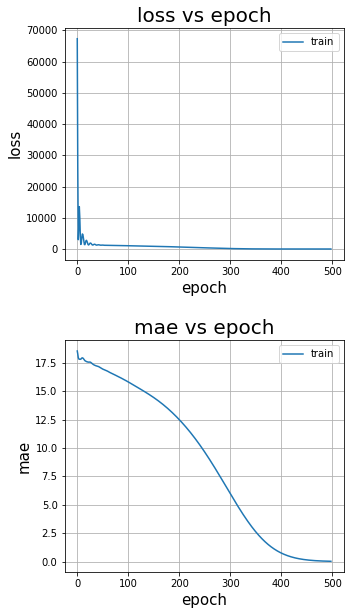

In [81]:
print(H.history.keys())
print("loss: ", H.history["loss"])
print("mae: ", H.history["mae"])
# print("val_loss: ", H.history["val_loss"])
# print("val_mae: ", H.history["val_mae"])

lim = 2

fig, ax = plt.subplots(2,1,figsize=(5,10))
fig.subplots_adjust(hspace=0.35)

ax[0].plot(H.history["loss"][lim:])
# ax[0].plot(H.history["val_loss"][lim:])
ax[0].set_title("loss vs epoch", fontsize=20)
ax[0].set_xlabel("epoch", fontsize=15)
ax[0].set_ylabel("loss", fontsize=15)
# ax[0].set_yscale("log")
ax[0].legend(["train","val"])
ax[0].grid(True)


ax[1].plot(H.history["mae"][lim:])
# ax[1].plot(H.history["val_mae"][lim:])
ax[1].set_title("mae vs epoch", fontsize=20)
ax[1].set_xlabel("epoch", fontsize=15)
ax[1].set_ylabel("mae", fontsize=15)
ax[1].legend(["train","val"])
ax[1].grid(True)


dict_keys(['loss', 'mae'])
loss:  [126944.15625, 125522.3984375, 124109.0546875, 122704.2421875, 121308.1015625, 119920.734375, 118542.296875, 117172.9140625, 115812.6953125, 114461.796875, 113120.296875, 111788.3046875, 110465.9296875, 109153.2890625, 107850.4453125, 106557.4921875, 105274.5546875, 104001.6484375, 102738.8984375, 101486.3046875, 100243.9921875, 99011.9765625, 97790.296875, 96579.0546875, 95378.234375, 94187.8671875, 93007.9921875, 91838.6484375, 90679.8203125, 89531.53125, 88393.8125, 87266.6640625, 86150.0546875, 85043.9609375, 83948.4375, 82863.4296875, 81788.9375, 80724.9375, 79671.390625, 78628.3046875, 77595.609375, 76573.28125, 75561.328125, 74559.640625, 73568.2421875, 72587.078125, 71616.0859375, 70655.21875, 69704.4609375, 68763.75, 67833.0078125, 66912.2109375, 66001.3203125, 65100.234375, 64208.93359375, 63327.3671875, 62455.44140625, 61593.12890625, 60740.3671875, 59897.09375, 59063.25, 58238.7421875, 57423.5625, 56617.60546875, 55820.84375, 55033.1796875,

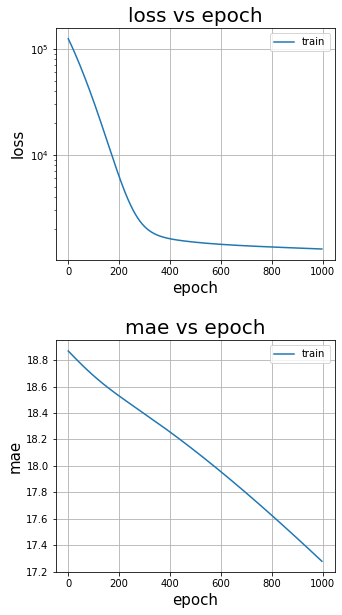

In [46]:
print(H.history.keys())
print("loss: ", H.history["loss"])
print("mae: ", H.history["mae"])
# print("val_loss: ", H.history["val_loss"])
# print("val_mae: ", H.history["val_mae"])

lim = 2

fig, ax = plt.subplots(2,1,figsize=(5,10))
fig.subplots_adjust(hspace=0.35)

ax[0].plot(H.history["loss"][lim:])
# ax[0].plot(H.history["val_loss"][lim:])
ax[0].set_title("loss vs epoch", fontsize=20)
ax[0].set_xlabel("epoch", fontsize=15)
ax[0].set_ylabel("loss", fontsize=15)
ax[0].set_yscale("log")
ax[0].legend(["train","val"])
ax[0].grid(True)


ax[1].plot(H.history["mae"][lim:])
# ax[1].plot(H.history["val_mae"][lim:])
ax[1].set_title("mae vs epoch", fontsize=20)
ax[1].set_xlabel("epoch", fontsize=15)
ax[1].set_ylabel("mae", fontsize=15)
ax[1].legend(["train","val"])
ax[1].grid(True)


# Graphs

In [ ]:
# Maybe copy over previous function and edit that?
def graph(pred, true, diff):

  values = ["u","v","sin(v)","cos(v)","sin(u)","cos(u)","s","ds","wire","glayer","z","time","dE_amp","q"]
  limits = [["todo"]]

  size = len(values)

  fig, axs = plt.subplots(4,size,figsize=(size*5,20))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)


  for i in range(size):
    (mu, sigma) = norm.fit(diff[:,i])
    print("data" , values[i] ," |: mu: ", mu, "sigma: " , sigma)
    _, bins, _ = axs[0,i].hist(diff[:,i], 20, density=True)
    y = norm.pdf(bins, mu, sigma)
    l = axs[0,i].plot(bins, y, 'r--', linewidth=2)

    axs[0,i].set_title(values[i] + ' diff')
    axs[0,i].set_ylabel('freq')
    axs[0,i].set_xlabel(values[i] + ' diff')

  #--------------------------------------
  # PREDICTED VS TRUE
  #--------------------------------------
    
  for i in range(size):
    axs[1,i].scatter(true[:,i],pred[:,i])
    axs[1,i].grid(True)

    axs[1,i].set_title(values[i] + ' (predicted vs true)')
    axs[1,i].set_ylabel('pred ' + values[i])
    axs[1,i].set_xlabel('true ' + values[i])

    # axs[1,i].set_xlim(limits[i])
    # axs[1,i].set_ylim(limits[i])
    # axs[1,i].plot(limits[i],limits[i], color='b')

  #--------------------------------------
  # DIFFERENCE VS TRUE
  #--------------------------------------

  for i in range(size):
    axs[2,i].scatter(true[:,i],diff[:,i])
    l, r = axs[2,i].get_xlim()
    axs[2,i].hlines(0, l, r)
    axs[2,i].grid(True)

    axs[2,i].set_title(values[i] + ' (difference vs true)')
    axs[2,i].set_ylabel('diff ' + values[i])
    axs[2,i].set_xlabel('true ' + values[i])

  #--------------------------------------
  # DIFFERENCE VS TRUE 2D HIST
  #--------------------------------------

  for i in range(size):
    axs[3,i].hist2d(true[:,i],diff[:,i],bins=20)

    axs[2,i].set_title(values[i] + ' (difference vs true)')
    axs[2,i].set_ylabel('diff ' + values[i])
    axs[2,i].set_xlabel('true ' + values[i])

  fig.show()


In [ ]:
def gen_test_data(x_test, y_test, size=1000):
  pred = model.predict(x_test)
  diff = pred - y_test
  return pred, y_test, diff

In [ ]:
graph(gen_test_data(x_test, y_test));

# Test model

In [ ]:
# make test function

# Verification of proper data processing

## Using Generator

In [ ]:
aax, aay = next(train_gen)
print(aax.shape)
print(aay.shape)

In [ ]:
print("x",aax[0])
print("y",aay[0])

## Non Genenerator

In [ ]:
for i in range(10):
  aax = x_train[i]
  aay = y_train[i]
  # print(aax.shape)
  # print(aay.shape)
  # print("x",aax)
  print("y",aay)

y [-4.805 -1.959  9.798  0.297 77.505]
y [-5.881  1.876 19.786 -0.007 85.963]
y [-13.532   2.467   1.919  -5.848 169.211]
y [ -2.51   -1.784   7.588   0.107 138.047]
y [-17.129   1.434  26.423  -0.118  77.014]
y [-51.732  -0.04   20.991  -0.511  62.764]
y [ -7.787  -2.598   6.704  -9.91  168.021]
y [-755.88    -2.511   56.192  -11.262  177.016]
y [-9.942 -1.74   6.379  0.622 62.467]
y [-3.746  0.884 14.103 -0.305 66.462]


## Graphs of Data

### filter_ignore

Filters out large and small values and graphs them

In [ ]:
def filter_ignore(var,min=None,max=None,bins=25,ylog=False,xlog=False,cut=True):
  list_ignore = []

  print("--== {} ==--\n".format(var))

  largest = 0
  smallest = 0
  for i in range(len(csv_train[var])):
    if csv_train[var][i] > csv_train[var][largest]:
      largest = i
    if csv_train[var][i] < csv_train[var][smallest]:
      smallest = i
  print("largest value:  ({}, {:.3f})".format(largest,csv_train[var][largest]))
  print("smallest value: ({}, {:.3f})".format(smallest,csv_train[var][smallest]))

  print("")

  if min:
    for i in range(len(csv_train[var])):
      if csv_train[var][i] < min:
        list_ignore.append(i)
    print("min IDs to ignore for '{}':".format(var))
    print(csv_train[var][list_ignore])
    print("")
  if max:
    for i in range(len(csv_train[var])):
      if csv_train[var][i] > max:
        list_ignore.append(i)
    print("max IDs to ignore for '{}':".format(var))
    print(csv_train[var][list_ignore])
    print("")
  if min and max:
    print("total IDs to ignore for '{}':".format(var))
    print(csv_train[var][list_ignore])
    print("")
    plt.hist(csv_train[var],range=[min,max],bins=bins)
  elif min:
    plt.hist(csv_train[var],range=[min,csv_train[var][largest]],bins=bins)
  elif max:
    plt.hist(csv_train[var],range=[csv_train[var][smallest],max],bins=bins)
  else:
    plt.hist(csv_train[var],bins=bins)
  
  plt.title(var)
  if cut:
    plt.xlim(left=min,right=max)
  if ylog:
    plt.yscale("log")
  if xlog:
    plt.xscale("log")
  plt.show()
  return list_ignore

--== q_over_pt ==--

largest value:  (3355, 381.860)
smallest value: (9135, -20149.830)

min IDs to ignore for 'q_over_pt':
1317    -4724.393347
1481    -7912.062393
3410    -7389.880383
8777    -9841.475468
9135   -20149.829875
9584    -5357.554147
Name: q_over_pt, dtype: float64



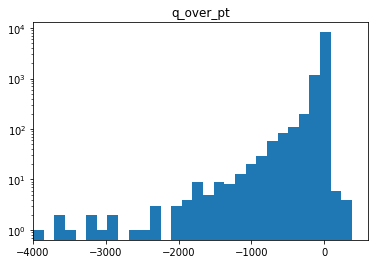

[1317, 1481, 3410, 8777, 9135, 9584]

In [ ]:
filter_ignore("q_over_pt",min=-4000,bins=30,ylog=True)

--== tanl ==--

largest value:  (9135, 1908.868)
smallest value: (2535, 0.001)

max IDs to ignore for 'tanl':
9135    1908.868217
Name: tanl, dtype: float64



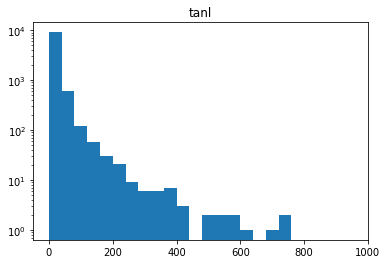

[9135]

In [ ]:
filter_ignore("tanl",max=1000,bins=25,ylog=True)

In [ ]:
rms_ignore = filter_ignore("rms",max=0.1,bins=25,ylog=True)

--== z ==--

largest value:  (5317, 340.485)
smallest value: (1775, -101.769)



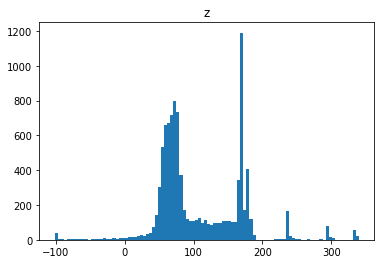

[]

In [ ]:
# 'q_over_pt', 'phi', 'tanl', 'D', 'z'
# filter_ignore("D", min=-200, ylog=True,bins=25)
filter_ignore("z",bins=100)

In [ ]:
csv_train.keys()

### 1D Hist of all Data

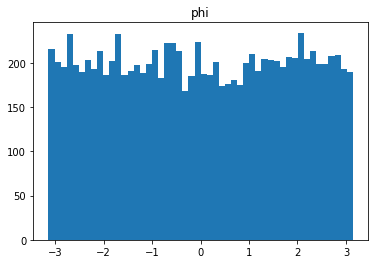

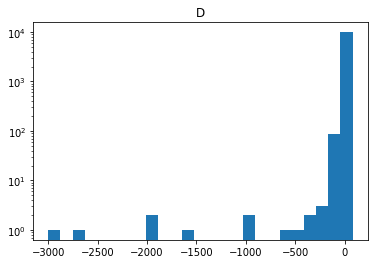

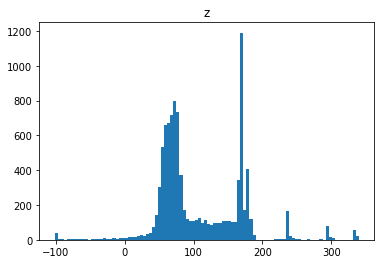

In [ ]:
plt.hist(csv_train["phi"],bins=50) # -3 to 3, even distrib
plt.title("phi")
plt.show()
# ---
plt.hist(csv_train["D"],range=[-3000,80],bins=25) # -3000 to 50, but val in 65
plt.yscale("log")
plt.title("D")
plt.show()
# ---
plt.hist(csv_train["z"],bins=100)
plt.title("z")
plt.show()

In [ ]:
# fig, ax = plt.subplots(2,1,figsize=(5,10))
# fig.subplots_adjust(hspace=0.35)

plt.hist(csv_train["cov_00"],range=[0,1e8],bins=25) # 0 to 1e13
plt.yscale("log")
plt.title("cov_00")
plt.show()
# ---
plt.hist(csv_train["cov_01"],bins=25) # -1e6 to over 1e5
plt.yscale("log")
plt.title("cov_01")
plt.show()
# ---
plt.hist(csv_train["chisq"],bins=25) # 0 to 200
plt.yscale("log")
plt.title("chisq")
plt.show()
# ---
plt.hist(csv_train["Ndof"],range=[0,44],bins=45) # ? this one weird 0 to ~43
plt.yscale("log")
plt.title("Ndof")
plt.show()
# ---
plt.hist(csv_train["rms"],range=[0,0.1],bins=25) # 
# plt.xscale("log")
plt.yscale("log")
plt.title("rms")
plt.show()
# ---
# plt.hist(csv_train["t_start_cntr"],bins=25) # -60 to ~50
plt.hist(csv_train[csv_train["t_start_cntr_valid"] == 1]["t_start_cntr"],bins=25) # -60 to ~50
plt.title("t_start_cntr")
plt.show()

# plt.hist(csv_train["t_tof"],bins=25) # ~-120 to ~175
plt.hist(csv_train[csv_train["t_tof_valid"] == 1]["t_tof"],bins=25) # ~-120 to ~175
plt.title("t_tof")
plt.show()
plt.hist(csv_train["t_bcal"],bins=25) # ~-22 to 20
plt.title("t_bcal")
plt.show()
plt.hist(csv_train["t_fcal"],bins=25) # ~-100 to ~75
plt.yscale("log")
plt.title("t_fcal")
plt.show()
# ---
plt.hist(csv_train["t_start_cntr_valid"],bins=25) # a lot more 0s
plt.title("t_start_cntr_valid")
plt.show()
plt.hist(csv_train["t_tof_valid"],bins=25) # about 5050
plt.title("t_tof_valid")
plt.show()
plt.hist(csv_train["t_bcal_valid"],bins=25) # almost all 0s
plt.title("t_bcal_valid")
plt.show()
plt.hist(csv_train["t_fcal_valid"],bins=25) # almost all 0s
plt.title("t_fcal_valid")
plt.show()
# ---



### 1D Hist of Hit1 Data

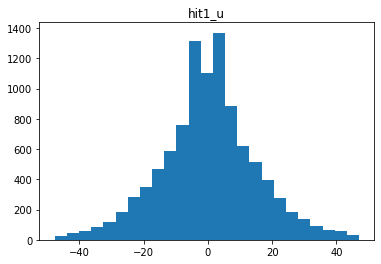

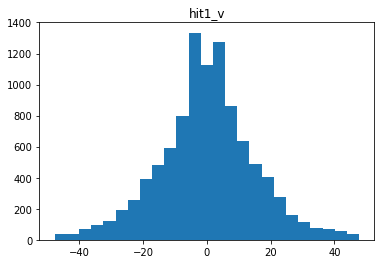

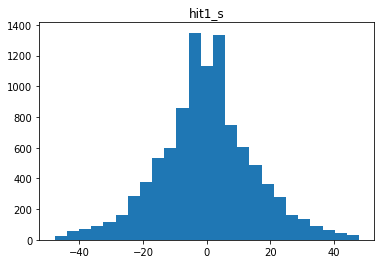

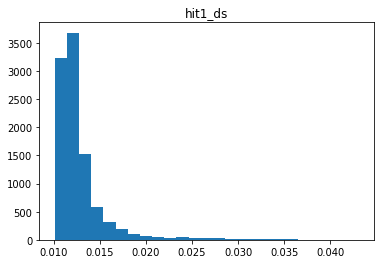

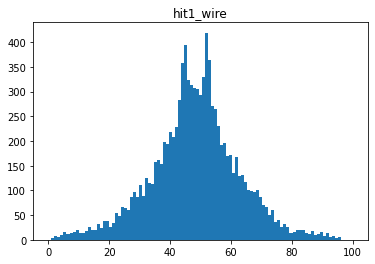

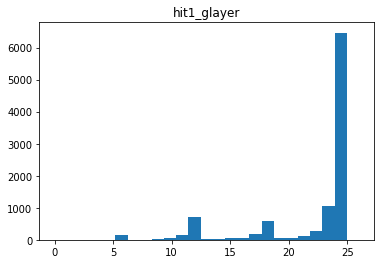

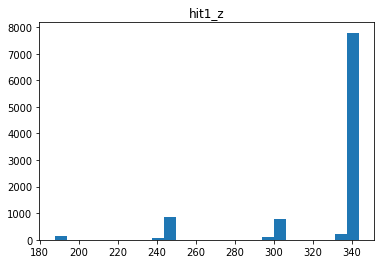

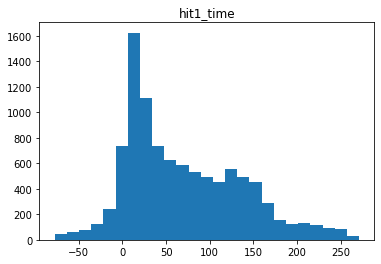

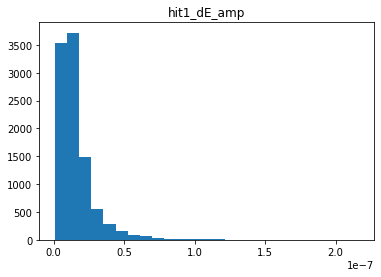

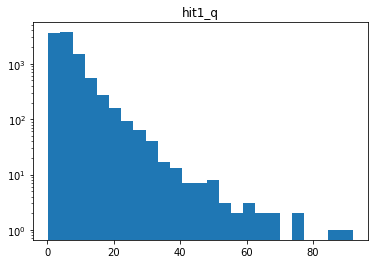

In [ ]:
plt.hist(csv_train["hit1_u"],bins=25) # -42 to 42
plt.title("hit1_u")
plt.show()
plt.hist(csv_train["hit1_v"],bins=25) # -42 to 42
plt.title("hit1_v")
plt.show()
# plt.hist(csv_train["hit1_sinv"],bins=25) # most are 0.96603 almost all are around that though
# plt.title("hit1_sinv")
# plt.show()
# plt.hist(csv_train["hit1_cosv"],bins=25) # most -0.2585
# plt.title("hit1_cosv")
# plt.show()
# plt.hist(csv_train["hit1_sinu"],bins=25) # most 0.96585
# plt.title("hit1_sinu")
# plt.show()
# plt.hist(csv_train["hit1_cosu"],bins=25) # most 0.2591
# plt.title("hit1_cosu")
# plt.show()
plt.hist(csv_train["hit1_s"],bins=25) # -42 to 42
plt.title("hit1_s")
plt.show()
plt.hist(csv_train["hit1_ds"],bins=25) # 0.01 to 0.04
plt.title("hit1_ds")
plt.show()
plt.hist(csv_train["hit1_wire"],bins=101,range=[0,100]) # 0 to 100
plt.title("hit1_wire")
plt.show()
plt.hist(csv_train["hit1_glayer"],bins=25,range=[0,26]) # 6 to 23
plt.title("hit1_glayer")
plt.show()
plt.hist(csv_train["hit1_z"],bins=25) # spaced out between 180 and 340
plt.title("hit1_z")
plt.show()
plt.hist(csv_train["hit1_time"],bins=25) # -75 to 270
plt.title("hit1_time")
plt.show()
plt.hist(csv_train["hit1_dE_amp"],bins=25) # 0 to 2e-7
plt.title("hit1_dE_amp")
plt.show()
plt.hist(csv_train["hit1_q"],bins=25) # 0 to 85
plt.yscale("log")
plt.title("hit1_q")
plt.show()
# ---

### 2D Scatters of various data

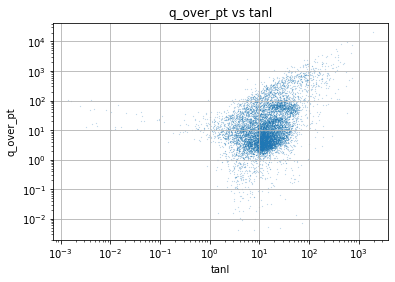

In [ ]:
plt.scatter(csv_train["tanl"],abs(csv_train["q_over_pt"]),s=0.01) # a lot more 0s
plt.title("q_over_pt vs tanl")
plt.xlabel("tanl")
plt.ylabel("q_over_pt")
plt.yscale("log")
plt.xscale("log")
plt.grid(True)
plt.show()

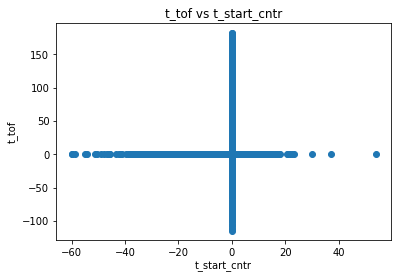

In [ ]:
# all create a plus sign
plt.scatter(csv_train["t_start_cntr"],csv_train["t_tof"]) # a lot more 0s
plt.title("t_tof vs t_start_cntr")
plt.xlabel("t_start_cntr")
plt.ylabel("t_tof")
plt.show()

# plt.hist(csv_train["t_start_cntr"],bins=25) # -60 to ~50
# plt.hist(csv_train["t_tof"],bins=25) # ~-120 to ~175
# plt.hist(csv_train["t_bcal"],bins=25) # ~-22 to 20
# plt.hist(csv_train["t_fcal"],bins=25) # ~-100 to ~75

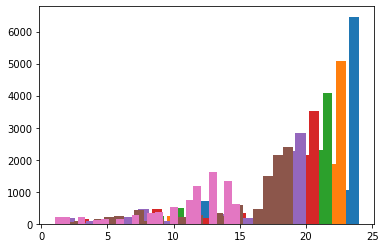

In [ ]:
plt.hist(csv_train["hit1_glayer"],bins=24)
plt.hist(csv_train["hit2_glayer"],bins=24)
plt.hist(csv_train["hit3_glayer"],bins=24)
plt.hist(csv_train["hit4_glayer"],bins=24)
plt.hist(csv_train["hit5_glayer"],bins=24)
plt.hist(csv_train["hit6_glayer"],bins=24)
plt.hist(csv_train["hit10_glayer"],bins=24)
plt.show()

### 2D Scatters of various hit data

In [ ]:
# Oval
plt.scatter(csv_train["hit1_u"],csv_train["hit1_v"]) # -3 to 3, even distrib
plt.title("v vs u")
plt.xlabel("u")
plt.ylabel("v")
plt.show()

# like a flame
plt.scatter(csv_train["hit1_s"],csv_train["hit1_ds"]) # -3 to 3, even distrib
plt.title("ds vs s")
plt.xlabel("s")
plt.ylabel("ds")
plt.show()

# hit1_wire, with single letters, forms an oval
plt.scatter(csv_train["hit1_wire"],csv_train["hit1_s"]) # -3 to 3, even distrib
plt.title("hit1_s vs hit1_wire")
plt.xlabel("hit1_wire")
plt.ylabel("hit1_s")
plt.show()

# go up in steps
plt.scatter(csv_train["hit1_glayer"],csv_train["hit1_z"]) # -3 to 3, even distrib
plt.title("z vs glayer")
plt.xlabel("glayer")
plt.ylabel("z")
plt.show()

# 1:1
plt.scatter(csv_train["hit1_q"],csv_train["hit1_dE_amp"]) # -3 to 3, even distrib
plt.title("dE_amp vs q")
plt.xlabel("q")
plt.ylabel("dE_amp")
plt.show()



In [ ]:
aax = 
plt.plot()